Model Pipeline:
1. Get the data(image size: 512 * 512 * 3), preprocess it and form train test split.
2. Make the U-Net model(i/p image size: 128 * 128 * 3 )
3.  Loss: Soft Dice Loss ,
    Accuracy Metric: IoU, 
    Activation Function: ReLU,
    Optimizer: Adam, 
    Epochs: 50,
    Batch_size= 8,
    BatchNormalization: Yes.
4. Compile model and run.
5. Run the model on test dataset.

In [1]:
import os
import tensorflow as tf
import numpy as np
import random
import cv2 
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras import backend as K
%matplotlib inline


Using TensorFlow backend.


In [2]:
#Size of the image to be fed to the UNET
width = 128
height = 128
channels =3

In [3]:
#First the file paths

path = 'D:\\AI\\Projects\\Image Segmentation\\roads\\Roads_512_small\\'

In [4]:
train_ids = next(os.walk(path+'train'))[2] #dir, folders, files
val_ids = next(os.walk(path+'val'))[2]
test_ids = next(os.walk(path+'test'))[2]

In [5]:
print('Number of training samples are: ', len(train_ids))
print('Number of validation samples are: ', len(val_ids))
print('Number of test samples are: ', len(test_ids))

Number of training samples are:  200
Number of validation samples are:  50
Number of test samples are:  100


In [6]:
X_train = np.zeros((len(train_ids), height,width, channels), dtype =np.uint8)
Y_train = np.zeros((len(train_ids), height, width, 1), dtype = np.bool)

val_X_train = np.zeros((len(val_ids), height,width, channels), dtype =np.uint8)
val_Y_train = np.zeros((len(val_ids), height, width, 1), dtype = np.bool)

X_test = np.zeros((len(test_ids), height,width, channels), dtype =np.uint8)
Y_test = np.zeros((len(test_ids), height, width, 1), dtype = np.bool)

In [7]:
print(Y_train.shape) 
print(val_Y_train.shape)
print(Y_test.shape)

(200, 128, 128, 1)
(50, 128, 128, 1)
(100, 128, 128, 1)


In [8]:
for n, file in tqdm(enumerate(train_ids), total = len(train_ids)):
    img = cv2.imread(path+'train\\'+file) 
    #input image size is 512*512*3
    img = cv2.resize(img, (height, width), interpolation = cv2.INTER_AREA) #resize the image to 128*128*3
    X_train[n] = img;
    
    #The masks are of type *.tif while training images are *.tif
    pathname = path+'train_labels\\' + file.strip('tiff') +'tif'

    #Since the images are rbg, convert them into black and white pictures using binary threshold using openCV
    
    mask = cv2.imread(pathname, 0) #Open the image as grayscale
    mask = cv2.resize(mask, (width, height), cv2.THRESH_BINARY)
    mask = np.expand_dims(mask, axis=-1) #increase the dimensions
    Y_train[n] = mask
  

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 26.15it/s]


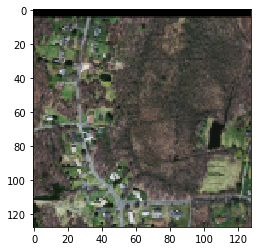

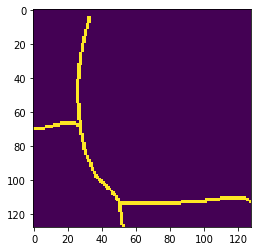

In [9]:
#Checking the images
plt.imshow(X_train[100])
plt.show()
plt.imshow(np.squeeze(Y_train[100]))
plt.show()

In [10]:
#Now perform the same operation for validation and test data set

In [11]:
#For making val_X_train and val_Y_train
for n, file in tqdm(enumerate(val_ids), total = len(val_ids)):
    img = cv2.imread(path+'val\\'+file)
    img = cv2.resize(img, (height, width), interpolation = cv2.INTER_AREA) 
    val_X_train[n] = img;
    
    pathname = path+'val_labels\\' + file.strip('tiff') +'tif'

    mask = cv2.imread(pathname, 0) 
    mask = cv2.resize(mask, (width, height), cv2.THRESH_BINARY)
    mask = np.expand_dims(mask, axis=-1) 

    val_Y_train[n] = mask

for n, file in tqdm(enumerate(test_ids), total = len(test_ids)):
    img = cv2.imread(path+'test\\'+file)
    img = cv2.resize(img, (height, width), interpolation = cv2.INTER_AREA) 
    X_test[n] = img;
    
    pathname = path+'test_labels\\' + file.strip('tiff') +'tif'
    mask = cv2.imread(pathname, 0) #Open the image as grayscale
    mask = cv2.resize(mask, (width, height), cv2.THRESH_BINARY)
    mask = np.expand_dims(mask, axis=-1) 
    Y_test[n] = mask

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.27it/s]


In [12]:
#---------------DONE WITH PREPROCESSING AND SPLITTING DATA INTO TRAIN, VAL AND TEST-----------------------------------

In [20]:
from model import *

In [21]:
model = model(height, width, channels)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 64, 64, 64)   0           conv2d_transpose_6[0][0]         
                                                                 batch_normalization_10[0][0]     
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 64, 64, 32)   18464       concatenate_6[0][0]              
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 64, 64, 32)   0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 64, 64, 32)   9248        dropout_16[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [22]:
#Model Checkpoint
#Create a callback to save the models weights whenever the val loss

cp = tf.keras.callbacks.ModelCheckpoint(path + 'test_model.h5', save_best_only = True, monitor='val_loss', verbose=1)

In [23]:
#Implement EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose =1, mode='min', patience = 10 )

In [24]:
results = model.fit(X_train, Y_train, validation_data = (val_X_train, val_Y_train), batch_size = 8, epochs = 50,callbacks =[cp], verbose=1)

Train on 200 samples, validate on 50 samples
Epoch 1/50
192/200 [===========================>..] - ETA: 21s - loss: 0.8921 - iou_coef: 0.051 - ETA: 11s - loss: 0.9048 - iou_coef: 0.047 - ETA: 7s - loss: 0.9153 - iou_coef: 0.042 - ETA: 5s - loss: 0.9113 - iou_coef: 0.04 - ETA: 4s - loss: 0.9036 - iou_coef: 0.04 - ETA: 4s - loss: 0.9057 - iou_coef: 0.04 - ETA: 3s - loss: 0.9062 - iou_coef: 0.04 - ETA: 2s - loss: 0.9048 - iou_coef: 0.04 - ETA: 2s - loss: 0.9021 - iou_coef: 0.04 - ETA: 2s - loss: 0.8955 - iou_coef: 0.05 - ETA: 2s - loss: 0.8907 - iou_coef: 0.05 - ETA: 1s - loss: 0.8884 - iou_coef: 0.05 - ETA: 1s - loss: 0.8856 - iou_coef: 0.05 - ETA: 1s - loss: 0.8855 - iou_coef: 0.05 - ETA: 1s - loss: 0.8808 - iou_coef: 0.05 - ETA: 1s - loss: 0.8756 - iou_coef: 0.06 - ETA: 0s - loss: 0.8747 - iou_coef: 0.06 - ETA: 0s - loss: 0.8755 - iou_coef: 0.06 - ETA: 0s - loss: 0.8756 - iou_coef: 0.06 - ETA: 0s - loss: 0.8731 - iou_coef: 0.06 - ETA: 0s - loss: 0.8716 - iou_coef: 0.06 - ETA: 0s - loss

192/200 [===========================>..] - ETA: 1s - loss: 0.6384 - iou_coef: 0.18 - ETA: 1s - loss: 0.5991 - iou_coef: 0.20 - ETA: 1s - loss: 0.6126 - iou_coef: 0.19 - ETA: 1s - loss: 0.6157 - iou_coef: 0.19 - ETA: 1s - loss: 0.6224 - iou_coef: 0.19 - ETA: 1s - loss: 0.6246 - iou_coef: 0.18 - ETA: 1s - loss: 0.6085 - iou_coef: 0.19 - ETA: 1s - loss: 0.6189 - iou_coef: 0.19 - ETA: 1s - loss: 0.6129 - iou_coef: 0.19 - ETA: 1s - loss: 0.6125 - iou_coef: 0.20 - ETA: 1s - loss: 0.6166 - iou_coef: 0.19 - ETA: 0s - loss: 0.6123 - iou_coef: 0.19 - ETA: 0s - loss: 0.6081 - iou_coef: 0.20 - ETA: 0s - loss: 0.6045 - iou_coef: 0.20 - ETA: 0s - loss: 0.6078 - iou_coef: 0.20 - ETA: 0s - loss: 0.6108 - iou_coef: 0.19 - ETA: 0s - loss: 0.6026 - iou_coef: 0.20 - ETA: 0s - loss: 0.6033 - iou_coef: 0.20 - ETA: 0s - loss: 0.6002 - iou_coef: 0.21 - ETA: 0s - loss: 0.5972 - iou_coef: 0.21 - ETA: 0s - loss: 0.5953 - iou_coef: 0.21 - ETA: 0s - loss: 0.5929 - iou_coef: 0.21 - ETA: 0s - loss: 0.5906 - iou_coef

192/200 [===========================>..] - ETA: 1s - loss: 0.4016 - iou_coef: 0.37 - ETA: 1s - loss: 0.3726 - iou_coef: 0.37 - ETA: 1s - loss: 0.3734 - iou_coef: 0.40 - ETA: 1s - loss: 0.3676 - iou_coef: 0.40 - ETA: 1s - loss: 0.3952 - iou_coef: 0.37 - ETA: 1s - loss: 0.3797 - iou_coef: 0.38 - ETA: 1s - loss: 0.3746 - iou_coef: 0.39 - ETA: 1s - loss: 0.3750 - iou_coef: 0.38 - ETA: 1s - loss: 0.3719 - iou_coef: 0.39 - ETA: 1s - loss: 0.3737 - iou_coef: 0.38 - ETA: 1s - loss: 0.3701 - iou_coef: 0.38 - ETA: 0s - loss: 0.3648 - iou_coef: 0.39 - ETA: 0s - loss: 0.3714 - iou_coef: 0.39 - ETA: 0s - loss: 0.3664 - iou_coef: 0.39 - ETA: 0s - loss: 0.3657 - iou_coef: 0.39 - ETA: 0s - loss: 0.3693 - iou_coef: 0.39 - ETA: 0s - loss: 0.3724 - iou_coef: 0.38 - ETA: 0s - loss: 0.3701 - iou_coef: 0.39 - ETA: 0s - loss: 0.3724 - iou_coef: 0.38 - ETA: 0s - loss: 0.3744 - iou_coef: 0.38 - ETA: 0s - loss: 0.3735 - iou_coef: 0.39 - ETA: 0s - loss: 0.3775 - iou_coef: 0.38 - ETA: 0s - loss: 0.3768 - iou_coef

192/200 [===========================>..] - ETA: 1s - loss: 0.2592 - iou_coef: 0.58 - ETA: 1s - loss: 0.2606 - iou_coef: 0.51 - ETA: 1s - loss: 0.3037 - iou_coef: 0.48 - ETA: 1s - loss: 0.3029 - iou_coef: 0.48 - ETA: 1s - loss: 0.3140 - iou_coef: 0.48 - ETA: 1s - loss: 0.3124 - iou_coef: 0.49 - ETA: 1s - loss: 0.3131 - iou_coef: 0.48 - ETA: 1s - loss: 0.3118 - iou_coef: 0.48 - ETA: 1s - loss: 0.3182 - iou_coef: 0.46 - ETA: 1s - loss: 0.3208 - iou_coef: 0.46 - ETA: 1s - loss: 0.3175 - iou_coef: 0.46 - ETA: 0s - loss: 0.3132 - iou_coef: 0.46 - ETA: 0s - loss: 0.3143 - iou_coef: 0.46 - ETA: 0s - loss: 0.3134 - iou_coef: 0.46 - ETA: 0s - loss: 0.3192 - iou_coef: 0.45 - ETA: 0s - loss: 0.3228 - iou_coef: 0.44 - ETA: 0s - loss: 0.3259 - iou_coef: 0.44 - ETA: 0s - loss: 0.3313 - iou_coef: 0.43 - ETA: 0s - loss: 0.3343 - iou_coef: 0.42 - ETA: 0s - loss: 0.3398 - iou_coef: 0.42 - ETA: 0s - loss: 0.3353 - iou_coef: 0.42 - ETA: 0s - loss: 0.3322 - iou_coef: 0.42 - ETA: 0s - loss: 0.3292 - iou_coef

192/200 [===========================>..] - ETA: 1s - loss: 0.2761 - iou_coef: 0.53 - ETA: 1s - loss: 0.3067 - iou_coef: 0.48 - ETA: 1s - loss: 0.2977 - iou_coef: 0.46 - ETA: 1s - loss: 0.2934 - iou_coef: 0.47 - ETA: 1s - loss: 0.2908 - iou_coef: 0.48 - ETA: 1s - loss: 0.2833 - iou_coef: 0.51 - ETA: 1s - loss: 0.2931 - iou_coef: 0.50 - ETA: 1s - loss: 0.2986 - iou_coef: 0.49 - ETA: 1s - loss: 0.3192 - iou_coef: 0.46 - ETA: 1s - loss: 0.3223 - iou_coef: 0.45 - ETA: 1s - loss: 0.3169 - iou_coef: 0.46 - ETA: 0s - loss: 0.3209 - iou_coef: 0.45 - ETA: 0s - loss: 0.3161 - iou_coef: 0.46 - ETA: 0s - loss: 0.3101 - iou_coef: 0.46 - ETA: 0s - loss: 0.3078 - iou_coef: 0.46 - ETA: 0s - loss: 0.3080 - iou_coef: 0.46 - ETA: 0s - loss: 0.3042 - iou_coef: 0.47 - ETA: 0s - loss: 0.3077 - iou_coef: 0.47 - ETA: 0s - loss: 0.3049 - iou_coef: 0.47 - ETA: 0s - loss: 0.3040 - iou_coef: 0.47 - ETA: 0s - loss: 0.3041 - iou_coef: 0.47 - ETA: 0s - loss: 0.3063 - iou_coef: 0.46 - ETA: 0s - loss: 0.3033 - iou_coef

192/200 [===========================>..] - ETA: 2s - loss: 0.3075 - iou_coef: 0.54 - ETA: 1s - loss: 0.2821 - iou_coef: 0.53 - ETA: 1s - loss: 0.2684 - iou_coef: 0.54 - ETA: 1s - loss: 0.2814 - iou_coef: 0.52 - ETA: 1s - loss: 0.2721 - iou_coef: 0.50 - ETA: 1s - loss: 0.2846 - iou_coef: 0.47 - ETA: 1s - loss: 0.2868 - iou_coef: 0.47 - ETA: 1s - loss: 0.2823 - iou_coef: 0.47 - ETA: 1s - loss: 0.2854 - iou_coef: 0.46 - ETA: 1s - loss: 0.2770 - iou_coef: 0.48 - ETA: 1s - loss: 0.2783 - iou_coef: 0.48 - ETA: 0s - loss: 0.2810 - iou_coef: 0.48 - ETA: 0s - loss: 0.2770 - iou_coef: 0.49 - ETA: 0s - loss: 0.2723 - iou_coef: 0.50 - ETA: 0s - loss: 0.2735 - iou_coef: 0.50 - ETA: 0s - loss: 0.2770 - iou_coef: 0.50 - ETA: 0s - loss: 0.2748 - iou_coef: 0.49 - ETA: 0s - loss: 0.2774 - iou_coef: 0.49 - ETA: 0s - loss: 0.2754 - iou_coef: 0.49 - ETA: 0s - loss: 0.2754 - iou_coef: 0.49 - ETA: 0s - loss: 0.2735 - iou_coef: 0.48 - ETA: 0s - loss: 0.2758 - iou_coef: 0.48 - ETA: 0s - loss: 0.2766 - iou_coef

192/200 [===========================>..] - ETA: 1s - loss: 0.1500 - iou_coef: 0.51 - ETA: 1s - loss: 0.1889 - iou_coef: 0.55 - ETA: 1s - loss: 0.1901 - iou_coef: 0.56 - ETA: 1s - loss: 0.2208 - iou_coef: 0.53 - ETA: 1s - loss: 0.2232 - iou_coef: 0.54 - ETA: 1s - loss: 0.2338 - iou_coef: 0.53 - ETA: 1s - loss: 0.2411 - iou_coef: 0.53 - ETA: 1s - loss: 0.2332 - iou_coef: 0.54 - ETA: 1s - loss: 0.2317 - iou_coef: 0.54 - ETA: 1s - loss: 0.2323 - iou_coef: 0.53 - ETA: 1s - loss: 0.2368 - iou_coef: 0.53 - ETA: 0s - loss: 0.2413 - iou_coef: 0.53 - ETA: 0s - loss: 0.2419 - iou_coef: 0.53 - ETA: 0s - loss: 0.2414 - iou_coef: 0.53 - ETA: 0s - loss: 0.2423 - iou_coef: 0.53 - ETA: 0s - loss: 0.2406 - iou_coef: 0.54 - ETA: 0s - loss: 0.2469 - iou_coef: 0.52 - ETA: 0s - loss: 0.2476 - iou_coef: 0.53 - ETA: 0s - loss: 0.2474 - iou_coef: 0.53 - ETA: 0s - loss: 0.2495 - iou_coef: 0.52 - ETA: 0s - loss: 0.2504 - iou_coef: 0.53 - ETA: 0s - loss: 0.2549 - iou_coef: 0.52 - ETA: 0s - loss: 0.2555 - iou_coef

192/200 [===========================>..] - ETA: 1s - loss: 0.3263 - iou_coef: 0.48 - ETA: 1s - loss: 0.2778 - iou_coef: 0.55 - ETA: 1s - loss: 0.2735 - iou_coef: 0.52 - ETA: 1s - loss: 0.2529 - iou_coef: 0.54 - ETA: 1s - loss: 0.2503 - iou_coef: 0.51 - ETA: 1s - loss: 0.2478 - iou_coef: 0.53 - ETA: 1s - loss: 0.2380 - iou_coef: 0.53 - ETA: 1s - loss: 0.2432 - iou_coef: 0.53 - ETA: 1s - loss: 0.2386 - iou_coef: 0.53 - ETA: 1s - loss: 0.2388 - iou_coef: 0.53 - ETA: 1s - loss: 0.2367 - iou_coef: 0.53 - ETA: 0s - loss: 0.2374 - iou_coef: 0.53 - ETA: 0s - loss: 0.2378 - iou_coef: 0.53 - ETA: 0s - loss: 0.2412 - iou_coef: 0.52 - ETA: 0s - loss: 0.2416 - iou_coef: 0.52 - ETA: 0s - loss: 0.2396 - iou_coef: 0.53 - ETA: 0s - loss: 0.2399 - iou_coef: 0.53 - ETA: 0s - loss: 0.2439 - iou_coef: 0.53 - ETA: 0s - loss: 0.2450 - iou_coef: 0.53 - ETA: 0s - loss: 0.2416 - iou_coef: 0.54 - ETA: 0s - loss: 0.2437 - iou_coef: 0.54 - ETA: 0s - loss: 0.2466 - iou_coef: 0.53 - ETA: 0s - loss: 0.2459 - iou_coef

192/200 [===========================>..] - ETA: 1s - loss: 0.1805 - iou_coef: 0.68 - ETA: 1s - loss: 0.1789 - iou_coef: 0.64 - ETA: 1s - loss: 0.2090 - iou_coef: 0.60 - ETA: 1s - loss: 0.2112 - iou_coef: 0.58 - ETA: 1s - loss: 0.2142 - iou_coef: 0.56 - ETA: 1s - loss: 0.2184 - iou_coef: 0.55 - ETA: 1s - loss: 0.2230 - iou_coef: 0.55 - ETA: 1s - loss: 0.2258 - iou_coef: 0.55 - ETA: 1s - loss: 0.2221 - iou_coef: 0.56 - ETA: 1s - loss: 0.2234 - iou_coef: 0.56 - ETA: 1s - loss: 0.2305 - iou_coef: 0.55 - ETA: 0s - loss: 0.2273 - iou_coef: 0.56 - ETA: 0s - loss: 0.2285 - iou_coef: 0.56 - ETA: 0s - loss: 0.2300 - iou_coef: 0.55 - ETA: 0s - loss: 0.2305 - iou_coef: 0.55 - ETA: 0s - loss: 0.2328 - iou_coef: 0.55 - ETA: 0s - loss: 0.2365 - iou_coef: 0.54 - ETA: 0s - loss: 0.2405 - iou_coef: 0.54 - ETA: 0s - loss: 0.2427 - iou_coef: 0.54 - ETA: 0s - loss: 0.2394 - iou_coef: 0.54 - ETA: 0s - loss: 0.2372 - iou_coef: 0.55 - ETA: 0s - loss: 0.2377 - iou_coef: 0.54 - ETA: 0s - loss: 0.2369 - iou_coef

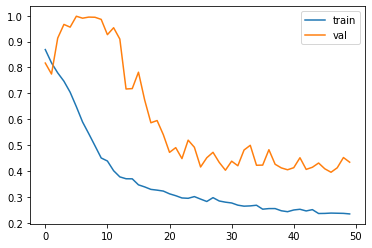

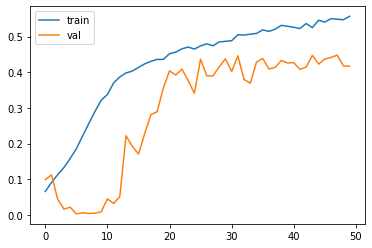

In [25]:
#Training Loss Vs. Validation Loss
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='val')
plt.legend()
plt.show()

#Training IoU Vs. Validation IoU
plt.plot(results.history['iou_coef'], label='train')
plt.plot(results.history['val_iou_coef'], label='val')
plt.legend()
plt.show()

In [26]:
model.evaluate(X_train, Y_train)

200/200 [==============================] - ETA: 4s - loss: 0.2397 - iou_coef: 0.48 - ETA: 2s - loss: 0.2044 - iou_coef: 0.57 - ETA: 1s - loss: 0.1971 - iou_coef: 0.58 - ETA: 0s - loss: 0.1900 - iou_coef: 0.59 - ETA: 0s - loss: 0.1949 - iou_coef: 0.59 - ETA: 0s - loss: 0.2029 - iou_coef: 0.59 - 1s 7ms/sample - loss: 0.2057 - iou_coef: 0.5928


[0.20566024780273437, 0.59281874]

In [27]:
#Generating the predictions
preds_test = model.predict(X_test, verbose =1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)


100/100 [==============================] - ETA:  - ETA:  - ETA:  - 1s 10ms/sample


In [28]:
print(preds_test_t.shape)

(100, 128, 128, 1)


Input Image:


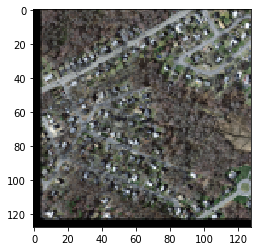

Expected Image:


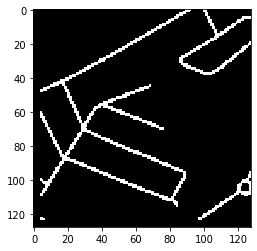

Predicted Mask:


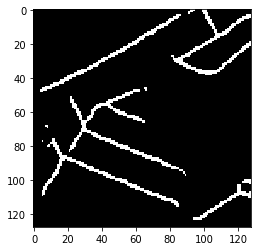

88


In [68]:
ix = 88
print('Input Image:')
plt.imshow(X_test[ix])
plt.show();

print('Expected Image:')
plt.imshow(np.squeeze(Y_test[ix]), cmap='gray')
plt.show();

print('Predicted Mask:')
plt.imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show();

print(ix)